# GPR Dashboard Widgets

Okay, the goal of this notebook is to expand our gpr `train_emulator()` func to include 2 parameters and the widget capability to show these plots.

Step 1:
Get Dashboard widgets working for 1 vs 1 plot

Step 2:
Adapt `train_emulator()` to process 2 params

Step 3:
Integrate an additional widget into the dashboard + updated function

Author: Sofia Ingersoll

Issues:
- Environment not updating with sobol and satilite, need these to implement Linnia's code


Kinks: 
- Make sure we're properly accessing pickle
- Plot titles match what will be selected via dashboard side, so we need to add the full names in dictionary for these to be called later

In [1]:
import xarray as xr
import pickle
from utils import * 

In [2]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(ad5ebe8c, 'tcp://128.117.208.88:44771', workers=1, threads=1, memory=9.31 GiB)

In [22]:
param, var, param_name, var_name = read_n_wrangle("medlynintercept","LNC")

In [27]:
param, var, param_name, var_name = read_n_wrangle("leafcn","LNC")

In [ ]:
param.shape

In [ ]:
var.shape

**Note** Not accessing pickle correctly

In [5]:
def train_emulator(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----   Load Pickled Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   # work in progress in GaiaFuture/Scripts/ML/Gaussian/gpr_pickling.ipynb
    # if it's already been queried and saved, pull it!
    # tis only names properly when inside dashboard function
    # commenting out now and adapting bc var is xr.da in this case
    filename = os.path.join("emulation_results", f"gpr_model_{var_name}.sav")
   
    if os.path.exists(filename):
        # load the model from disk
        loaded_model = pickle.load(open(filename, 'rb'))
        
    else:
        print(f"Emulator is running, this may take a few moments")
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))
   
   
     # using an out of the box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel,
                                        # want 20 random starts
                                        n_restarts_optimizer=20,
                                        # setting seed
                                        random_state=99,
                                        normalize_y=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gpr_model = gpr_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gpr_model.predict(X_test, return_std=True)


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gpr_model.score(X_train, y_train)

    # Accuracy Score
    #accuracy = accuracy_score(y_test, y_pred)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate R^2
    r2_train = r2_score(y_test, y_pred, force_finite = True)
    
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    #results_df['Accuracy Score'] = accuracy
    results_df['Mean Absolute Error'] = mae
    
   
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Pickle Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # save the model to disk
    pickle.dump(gpr_model, open(filename, 'wb')) 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Print Metrics         ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Print Training Metrics
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)
    print("Mean Absolute Error:", mae)
    print("Training Score:", train_score)
    
    return gpr_model, X_train, X_test, y_pred, y_std, y_test

In [28]:
gpr_model, X_train, X_test, y_pred, y_std, y_test = train_emulator(param, var)

Training R^2: 0.9425140697756845
Training RMSE: 0.04635041296076164
Mean Absolute Error: 0.0363568749639293
Training Score: 1.0


# Index param name
I've updated the titles to call the name variables, however, we can add the full length names for each of these as attributes in a dictionary to use in the dashboard 

In [ ]:
gpr_model

In [7]:
def plot_emulator(gpr_model):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    # save names
    param_title = param_name.title()
    var_title = var_name.title()

    # index parameter name
    # store the parameter names to index later
    global param_names
    param_names = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    
    indexed_param = param_names.get(param_name.upper())
    
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    
    #For the parameter of interest, replace the 0.5 with a range of values between 0 and 1
    X_values[:, indexed_param] = np.linspace(0, 1, 10)  # Set the 15th column values to evenly spaced values from 0 to 1

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_pred, y_std = gpr_model.predict(X_values, return_std=True)
    coef_deter = r2_score(y_test[:10],y_pred[:10], force_finite = True)

    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    plt.plot(X_values[:, indexed_param],
             y_pred[:10,],
             color='#134611',
             label='GPR Prediction')

    plt.text(0,1,
             'R2_score = '+str(np.round(coef_deter,2)),
             fontsize=10)
    
    # applying z-score for 99.7% CI
    plt.fill_between(X_values[:, indexed_param],
                     y_pred[:10] - z_score * y_std[:10], y_pred[:10] + z_score * y_std[:10],
                     alpha=0.5, 
                     color='#9d6b53',
                     label = '3 St.Dev., Confidence Interval')

   
    
    plt.xlabel(f'Perturbed Parameter: {param_title}')
    plt.ylabel(f'Variable: {var_title} ')
    plt.title('Parameter Perturbation Uncertainty Estimation')
    
    plt.legend()

     # Save the plot as a PNG file
    plt.savefig(f'plots/emulator/emulator_plot_{var_name}.png')
    
    return plt.show()

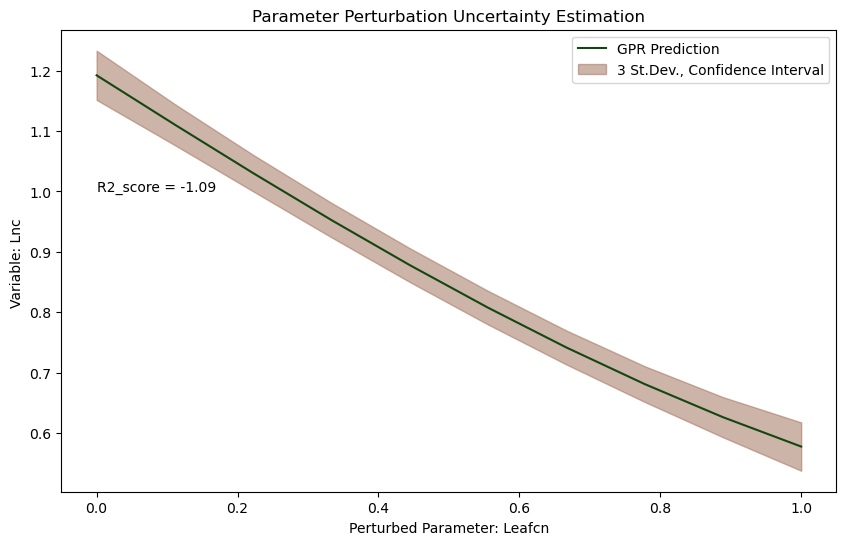

In [29]:
emulator_plot = plot_emulator(gpr_model)

In [9]:
def plot_accuracy(y_test, y_pred, y_std):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Accuracy      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    # save names
    param_title = param_name.title()
    var_title = var_name.title()

    # index parameter name
    # store the parameter names to index later
    global param_names
    param_names = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    
    indexed_param = param_names.get(param_name.upper())
    
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    
    #For the parameter of interest, replace the 0.5 with a range of values between 0 and 1
    X_values[:, indexed_param] = np.linspace(0, 1, 10)  # Set the 15th column values to evenly spaced values from 0 to 1

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_pred, y_std = gpr_model.predict(X_values, return_std=True)
    coef_deter = r2_score(y_test[:10],y_pred[:10], force_finite = True)

    
    # save names
    param_title = param_name.title()
    var_title = var_name.title()
    
    plt.errorbar(y_test[:10],
             y_pred[:10],
             yerr=3*y_std[:10],
             fmt="o",
             color='#134611',
             elinewidth=1,  # Increase the width of the error bar lines
             capsize=5)     # Increase the size of the caps on the error bars

    plt.text(-0.3,np.max(y_test),
             'R2_score = '+str(np.round(coef_deter,2)),
             fontsize=10)
    
    plt.plot([0,np.max(y_test)],
             [0,np.max(y_pred)],
             linestyle='--',
             c='k')
    
    plt.xlim([np.min(y_test)-1,np.max(y_test)+1])
    plt.ylim([np.min(y_pred)-1,np.max(y_pred)+1])

    plt.xlabel(f'Perturbed Parameter: {param_title}')
    plt.ylabel(f'Variable: {var_title} ')
    plt.title('Emulator Validation')
    
    plt.tight_layout()

     # Save the plot as a PNG file
    plt.savefig(f'plots/accuracy/accuracy_plot_{var_name}.png')

    return plt.show()

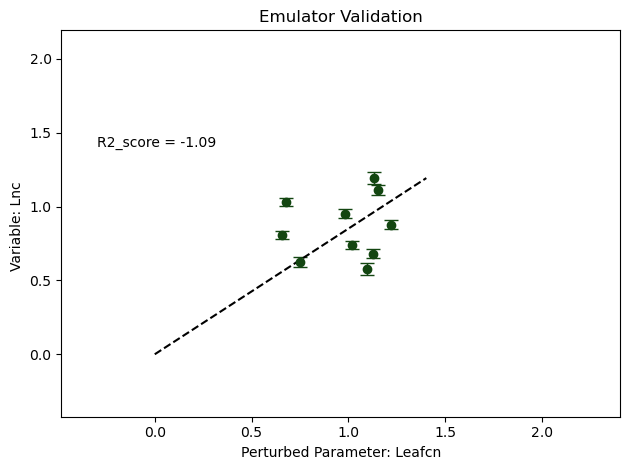

In [30]:
plot_accuracy(y_test, y_pred, y_std)

### Linnia's Sobol Sensitivity
Sobol sensitivity analysis offers a comprehensive assessment of the relative importance of parameters and their interactions, which can be crucial for understanding the model's behavior across the entire parameter space.

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

# fourier amplitude sensitivity test w/emulator
problem = {
    'names': lhc_params.columns,
    'num_vars': num_params,
    'bounds': [[0, 1]],
}

sample = saltelli.sample(problem, 1024)
Y, _ = gpr_model.predict_f(sample)
Sobol = sobol.analyze(problem, Y.numpy().flatten())

df_Sobol = pd.DataFrame({'S1':Sobol['S1'],'ST':Sobol['ST']},index = lhc_params.columns)
df_Sobol = df_Sobol.sort_values(by=['ST'],ascending=False)

plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

ax = plt.subplot(1,1,1)
ax.bar(df_Sobol.index,df_Sobol['ST'],color='lightgrey',label='interactions')
ax.bar(df_Sobol.index,df_Sobol['S1'],color='darkolivegreen',label='main effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.legend(loc='upper right')
plt.ylabel('Sobol sensitivity')
plt.title('Global mean annual mean LAI')
plt.tight_layout()

In [ ]:
gpr_model

# Dashboard

In [ ]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        params, var_avg, param_name, var_name = read_n_wrangle(param, var)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Train Emulator Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
    gpr_model, X_train, X_test, y_pred, y_std, y_test = train_emulator(param, var)
    

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Plot Emulation Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    Plot_1 = plot_emulation()

  
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----       Plot Accuracy Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    Plot_2 = plot_accuracy()


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----     Plot Sensitivity Function      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    Plot_3 = plot_FAST()


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----     Plot Panel Wrapper Function    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    global plot_pane1, plot_pane2, plot_pane3
    plot_pane1 = pn.pane.Matplotlib(Plot_1)
    plot_pane2 = pn.pane.Matplotlib(Plot_2)
    plot_pane3 = pn.pane.Matplotlib(Plot_3)

    # output panel pane plots 
    return plot_pane1, plot_pane2, plot_pane3

In [ ]:
dashboard_wrangling('leafcn','LNC')

In [ ]:
class Selections(param.Parameterized):
    parameter = param.Selector(objects=['leafcn'])
    variable = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])

    def view(self):
        # Call dashboard_wrangling with the selected parameter and variable
        plots = dashboard_wrangling_check2(self.parameter, self.variable)

    # Return a Panel layout containing the converted Panel objects
        return pn.Column(plot_pane1, plot_pane2, plot_pane3)

# Create an instance of Selections and display it using Panel
obj = Selections()
pn.Row(obj.param, obj.view).servable()

In [ ]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    return train_emulator(params, var_avg)

In [ ]:
class Selections(param.Parameterized):
    parameter = param.Selector(objects=['leafcn'])
    variable = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])

    def view(self):
        # Call dashboard_wrangling with the selected parameter and variable
        plots = dashboard_wrangling_check2(self.parameter, self.variable)

        # Convert Matplotlib figures to Panel objects
        plot_pane1 = pn.pane.Matplotlib(plots[0])
        plot_pane2 = pn.pane.Matplotlib(plots[1])
        plot_pane3 = pn.pane.Matplotlib(plots[2])

        # Return a Panel layout containing the converted Panel objects
        return pn.Column(plot_pane1, plot_pane2)

# Create an instance of Selections and display it using Panel
obj = Selections()
pn.Row(obj.param, obj.view).servable()

## Fourier Amplitude Sensitivity Transformation Anaylsis
Provides insights into the periodic behavior or dominant frequencies in the model output.

This doesn't match what Linnia provided -- pulled from Sujan's GaiaFuture notebook

In [19]:
 def create_parameter_names_dict():
            data = {
                key.upper(): value for key, value in {
                    'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
                    'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
                    'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
                    'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
                    'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
                    'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
                }.items()
            }
            return data


param_df = create_parameter_names_dict()

In [20]:
#Fast plot
def plot_FAST(model):
    
    # Define a custom function to generate the Gaussian regression line for each parameter
    def gaussian_regression_lines(model):

        # this doesn't work inside func
        def create_parameter_names_dict():
            data = {
                key.upper(): value for key, value in {
                    'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
                    'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
                    'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
                    'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
                    'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
                    'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
                }.items()
            }
            return data

        param_df = create_parameter_names_dict()
        
        fourier_amplitudes = []  # List to store Fourier amplitudes for each parameter
        
        for param_index in range(32):
            # Generate x_values with 32 dimensions
            x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
            x_values[:, param_index] = np.linspace(0, 1, 10)  # Set the current parameter values to evenly spaced values from 0 to 1

            # Predict mean and standard deviation of the Gaussian process at each point in x_values
            y_mean, _ = model.predict(x_values, return_std=True)

            # Compute Fourier transform of the model output
            y_fft = fft(y_mean)

            # Compute amplitude of each frequency component
            amplitude = np.abs(y_fft)

            # Store the amplitude corresponding to the first non-zero frequency (excluding DC component)
            fourier_amplitudes.append(amplitude[1])

        return fourier_amplitudes

    # Calculate Fourier amplitudes
    fourier_amplitudes = gaussian_regression_lines(gpr_model)

    # Sort parameters based on Fourier amplitudes in descending order
    sorted_indices = np.argsort(fourier_amplitudes)
    sorted_fourier_amplitudes = np.array(fourier_amplitudes)[sorted_indices]
    
    # Swapping keys and values using a dictionary comprehension
    swapped_param_keys = {v: k for k, v in create_parameter_names_dict().items()}

    # Extract parameter names corresponding to sorted indices from lookup table
    sorted_parameter_names = [swapped_param_keys[index] for index in sorted_indices]

    # Plot horizontal bar chart
    plt.figure(figsize=(16, 8))
    plt.barh(range(len(sorted_fourier_amplitudes)), sorted_fourier_amplitudes, color='darkolivegreen')
    plt.ylabel('')
    plt.xlabel('Fourier Amplitude')
    plt.title(f'Fourier amplitude sensitivity test(FAST) for {var_name}')
    plt.yticks(range(len(sorted_fourier_amplitudes)), sorted_parameter_names)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().set_aspect('auto', adjustable='box')
    # Save the plot as a PNG file
    plt.savefig(f'plots/FAST/sensitivity_plot_{var_name}.png')

    return plt.show()

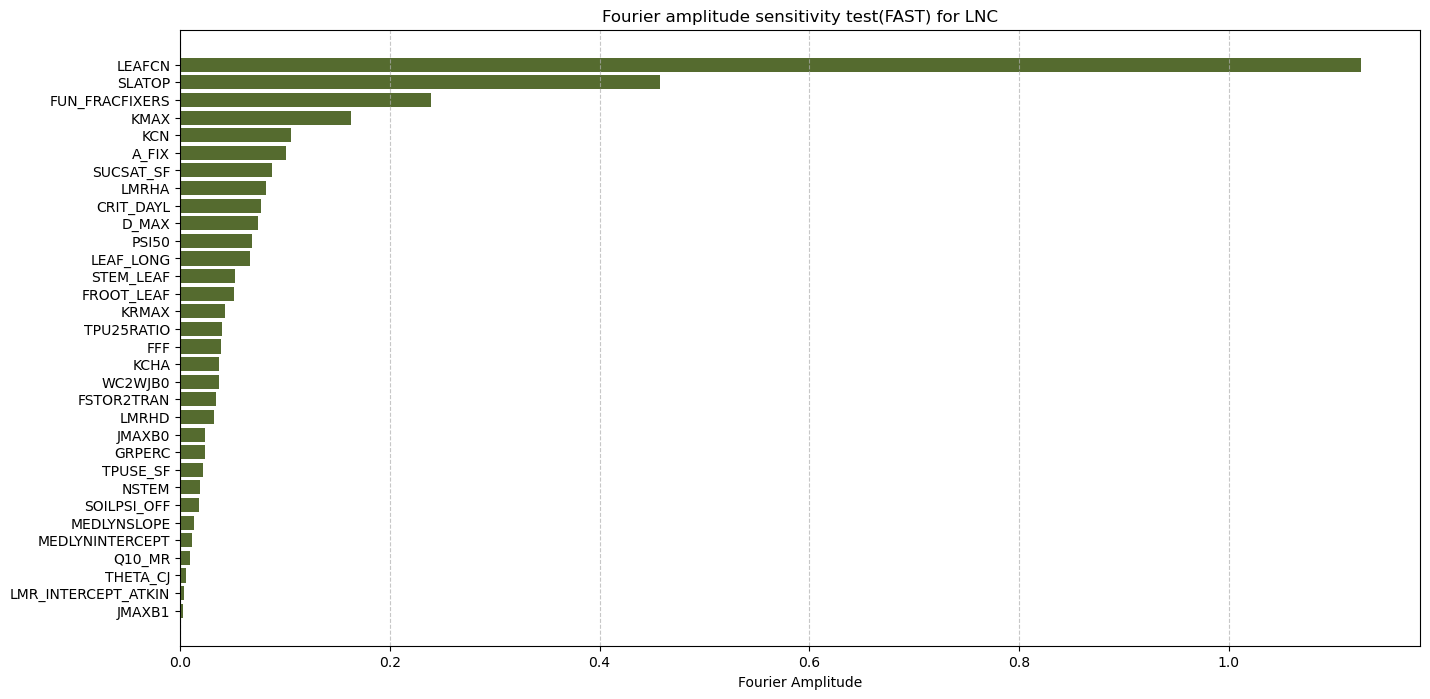

In [26]:
plot_FAST(gpr_model)